#  第3章 k近邻法

1．$k$近邻法是基本且简单的分类与回归方法。$k$近邻法的基本做法是：对给定的训练实例点和输入实例点，首先确定输入实例点的$k$个最近邻训练实例点，然后利用这$k$个训练实例点的类的多数来预测输入实例点的类。

2．$k$近邻模型对应于基于训练数据集对特征空间的一个划分。$k$近邻法中，当训练集、距离度量、$k$值及分类决策规则确定后，其结果唯一确定。

3．$k$近邻法三要素：距离度量、$k$值的选择和分类决策规则。常用的距离度量是欧氏距离及更一般的$L_p$距离。$k$值小时，$k$近邻模型更复杂, 近似误差(approximation error)会减小, 但估计误差(estimation error)会增大,容易受到噪声的影响；$k$值大时，$k$近邻模型更简单。$k$值的选择反映了对近似误差与估计误差之间的权衡，通常由交叉验证选择最优的$k$。

常用的分类决策规则是多数表决，对应于经验风险最小化。

4．$k$近邻法的实现需要考虑如何快速搜索k个最近邻点。**kd**树是一种便于对k维空间中的数据进行快速检索的数据结构。kd树是二叉树，表示对$k$维空间的一个划分，其每个结点对应于$k$维空间划分中的一个超矩形区域。利用**kd**树可以省去对大部分数据点的搜索， 从而减少搜索的计算量。

### 距离度量

设特征空间$x$是$n$维实数向量空间 ，$x_{i}, x_{j} \in \mathcal{X}$,$x_{i}=\left(x_{i}^{(1)}, x_{i}^{(2)}, \cdots, x_{i}^{(n)}\right)^{\mathrm{T}}$,$x_{j}=\left(x_{j}^{(1)}, x_{j}^{(2)}, \cdots, x_{j}^{(n)}\right)^{\mathrm{T}}$
，则：$x_i$,$x_j$的$L_p$距离定义为:


$L_{p}\left(x_{i}, x_{j}\right)=\left(\sum_{i=1}^{n}\left|x_{i}^{(i)}-x_{j}^{(l)}\right|^{p}\right)^{\frac{1}{p}}$

- $p= 1$  曼哈顿距离
- $p= 2$  欧氏距离
- $p= \infty$   切比雪夫距离

In [1]:
import math
from itertools import combinations

In [2]:
def L(x, y, p=2):
    # x1 = [1, 1], x2 = [5,1]
    if len(x) == len(y) and len(x) > 1:
        sum = 0
        for i in range(len(x)):
            sum += math.pow(abs(x[i] - y[i]), p)
        return math.pow(sum, 1 / p)
    else:
        return 0

### 课本例3.1

In [4]:
x1 = [1, 1]
x2 = [5, 1]
x3 = [4, 4]

In [5]:
# x1, x2
for i in range(1, 5):
    r = {'1-{}'.format(c): L(x1, c, p=i) for c in [x2, x3]}
    print(min(zip(r.values(), r.keys())))

(4.0, '1-[5, 1]')
(4.0, '1-[5, 1]')
(3.7797631496846193, '1-[4, 4]')
(3.5676213450081633, '1-[4, 4]')


python实现，遍历所有数据点，找出$n$个距离最近的点的分类情况，少数服从多数

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter
np.set_printoptions(precision=4, threshold=15,suppress=True)
pd.options.display.max_rows = 20

In [7]:
# data
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
# data = np.array(df.iloc[:100, [0, 1, -1]])

In [8]:
df

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


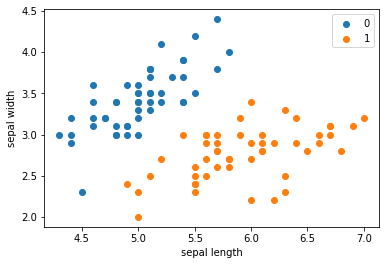

In [9]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [ ]:
# train_test_split?
# Split arrays or matrices into random train and test subsets 
# >>> X_train, X_test, y_train, y_test = train_test_split(
# ...     X, y, test_size=0.33, random_state=42)

In [10]:
data = np.array(df.iloc[:100, [0, 1, -1]])
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
class KNN:
    def __init__(self, X_train, y_train, n_neighbors=3, p=2):
        """
        parameter: n_neighbors 临近点个数
        parameter: p 距离度量
        """
        self.n = n_neighbors
        self.p = p
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X):
        # 取出n个点
#         knn_list = []
#         for i in range(self.n):  # 先取n个点 计算出这些点与X的距离
#             dist = np.linalg.norm(X - self.X_train[i], ord=self.p)  # 距离为Lp范数
#             knn_list.append((dist, self.y_train[i]))

#         for i in range(self.n, len(self.X_train)):
#             # 剩下的点中, 与x距离如果小于之前的n个,则更新成更小的点
#             max_index = knn_list.index(max(knn_list, key=lambda x: x[0]))
#             dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
#             if knn_list[max_index][0] > dist:
#                 knn_list[max_index] = (dist, self.y_train[i])
        
        # 寻找X_train中与X最近的n个点
        distances = list(map(lambda point: np.linalg.norm(X - point, ord=self.p), self.X_train))
        knn_list = np.argsort(distances)[:self.n]
        

        # 统计 最近的n个点的类别
        # knn = [k[-1] for k in knn_list]
        knn = [self.y_train[i] for i in knn_list]
        count_pairs = Counter(knn)
#         max_count = sorted(count_pairs, key=lambda x: x)[-1]
#         max_count = sorted(count_pairs.items(), key=lambda x: x[1])[-1][0]
        max_count = count_pairs.most_common()[0][0]  # (数据: 出现次数)
        return max_count

    def score(self, X_test, y_test):
        # 计算正确率
        right_count = 0
        n = 10
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if label == y:
                right_count += 1
        return right_count / len(X_test)

In [11]:
l = ['1', '2', '2', '1', '3', '2', '4']
c = Counter(l)
c.most_common()[0][0]

'2'

In [13]:
clf = KNN(X_train, y_train)

In [14]:
test_point = [5.0, 4.0]
print('Test Point: {}'.format(clf.predict(test_point)))

Test Point: 0.0


In [15]:
clf.score(X_test, y_test)

1.0

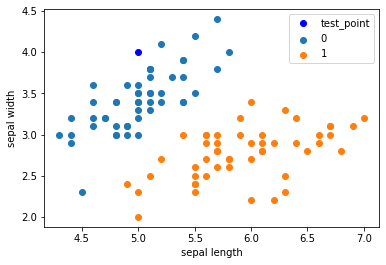

In [16]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.plot(test_point[0], test_point[1], 'bo', label='test_point')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

### scikit-learn实例

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
clf_sk = KNeighborsClassifier(algorithm='kd_tree')
clf_sk.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree')

In [19]:
clf_sk.score(X_test, y_test)

1.0

In [20]:
clf_sk.predict([[5.0, 3.3]])
# 参数X: array-like, shape (n_query, n_features),

array([0.])

### kd树 k-dimension tree

**kd**树是一种对k维空间中的实例点进行存储以便对其进行快速检索的树形数据结构。

**kd**树是二叉树，表示对$k$维空间的一个划分（partition）。构造**kd**树相当于不断地用垂直于坐标轴的超平面将$k$维空间切分，构成一系列的k维超矩形区域。kd树的每个结点对应于一个$k$维超矩形区域。

KD tree 的查询时间 的变化是很难精确描述的.对于较小的 D (小于20) 的成本大约是 O[DNlog(N)], 并且 KD 树更加有效.对于较大的 D 成本的增加接近 O[DN], 由于树结构引起的开销会导致查询效率比暴力还要低.

构造**kd**树的方法如下：

构造根结点，使根结点对应于$k$维空间中包含所有实例点的超矩形区域；通过下面的递归方法，不断地对$k$维空间进行切分，生成子结点。在超矩形区域（结点）上选择一个坐标轴和在此坐标轴上的一个切分点，确定一个超平面，这个超平面通过选定的切分点并垂直于选定的坐标轴，将当前超矩形区域切分为左右两个子区域
（子结点）；这时，实例被分到两个子区域。这个过程直到子区域内没有实例时终止（终止时的结点为叶结点）。在此过程中，将实例保存在相应的结点上。

通常，依次选择坐标轴对空间切分，选择训练实例点在选定坐标轴上的中位数
（median）为切分点，这样得到的**kd**树是平衡的。注意，平衡的**kd**树搜索时的效率未必是最优的。


### 构造平衡kd树算法
输入：$k$维空间数据集$T＝\{x_1，x_2,…,x_N\}$，

其中$x_{i}=\left(x_{i}^{(1)}, x_{i}^{(2)}, \cdots, x_{i}^{(k)}\right)^{\mathrm{T}}$ ，$i＝1,2,…,N$；

输出：**kd**树。

（1）开始：构造根结点，根结点对应于包含$T$的$k$维空间的超矩形区域。

选择$x^{(1)}$为坐标轴，以T中所有实例的$x^{(1)}$坐标的中位数为切分点，将根结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。

由根结点生成深度为1的左、右子结点：左子结点对应坐标$x^{(1)}$小于切分点的子区域， 右子结点对应于坐标$x^{(1)}$大于切分点的子区域。

将落在切分超平面上的实例点保存在根结点。

（2）重复：对深度为$j$的结点，选择$x^{(1)}$为切分的坐标轴，$l＝j(modk)+1$，以该结点的区域中所有实例的$x^{(1)}$坐标的中位数为切分点，将该结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。

由该结点生成深度为$j+1$的左、右子结点：左子结点对应坐标$x^{(1)}$小于切分点的子区域，右子结点对应坐标$x^{(1)}$大于切分点的子区域。

将落在切分超平面上的实例点保存在该结点。

（3）直到两个子区域没有实例存在时停止。从而形成**kd**树的区域划分。

In [21]:
# kd-tree每个结点中主要包含的数据结构如下
class KdNode:
    def __init__(self, dom_elt, split, left, right):
        self.dom_elt = dom_elt  # k维向量节点(k维空间中的一个样本点)
        self.split = split  # 整数（使用哪一个维度进行分割）
        self.left = left  # 该结点分割超平面左子空间构成的kd-tree
        self.right = right  # 该结点分割超平面右子空间构成的kd-tree

# 二叉排序树, 左子节点 不大于根节点; 右子节点不小于根节点
class KdTree:
    def __init__(self, data):
        k = len(data[0])  # 数据维度

        def create_node(split, data_set):  # 按第split维划分数据集exset创建KdNode
            if not data_set:  # 数据集为空
                return None
            # key参数的值为一个函数，此函数只有一个参数且返回一个值用来进行比较
            # operator模块提供的itemgetter函数用于获取对象的哪些维的数据，参数为需要获取的数据在对象中的序号
            #data_set.sort(key=itemgetter(split)) # 按要进行分割的那一维数据排序
            data_set.sort(key=lambda x: x[split])
            split_pos = len(data_set) // 2  # 确定此节点放置的数据的序号
            median = data_set[split_pos]  # 中位数分割点
            split_next = (split + 1) % k  # cycle coordinates 下一个节点分割使用的维度

            # 递归的创建kd树
            return KdNode(
                median,
                split,
                create_node(split_next, data_set[:split_pos]),  # 创建左子树
                create_node(split_next, data_set[split_pos + 1:]))  # 创建右子树

        self.root = create_node(0, data)  # 从第0维分量开始构建kd树,返回根节点


# KDTree的前序遍历  DLR
def preorder(root):
    print(root.dom_elt)
    if root.left:  # 节点不为空
        preorder(root.left)
    if root.right:
        preorder(root.right)

**最近邻搜索** k=1 的特殊情形

In [22]:
# 对构建好的kd树进行搜索，寻找与目标点最近的样本点：
from math import sqrt
from collections import namedtuple

# 定义一个namedtuple,分别存放最近坐标点、最近距离和访问过的节点数
result = namedtuple("Result_tuple",
                    "nearest_point  nearest_dist  nodes_visited")


def find_nearest(tree, point):
    k = len(point)  # 数据维度

    def travel(kd_node, target, max_dist):
        # kd_node: 当前访问的节点
        # target: 目标节点
        # 
        if kd_node is None:
            return result([0] * k, float("inf"),
                          0)  # python中用float("inf")和float("-inf")表示正负无穷

        nodes_visited = 1

        s = kd_node.split  # 进行分割的维度
        pivot = kd_node.dom_elt  # 进行分割的“轴”, 当前节点的保存的样本数据

        if target[s] <= pivot[s]:  # 如果目标点第s维小于分割轴的对应值(目标离左子树更近)
            nearer_node = kd_node.left  # 下一个访问节点为左子树根节点
            further_node = kd_node.right  # 同时记录下右子树
        else:  # 目标离右子树更近
            nearer_node = kd_node.right  # 下一个访问节点为右子树根节点
            further_node = kd_node.left
        
        # 进入子节点开始 递归查找 直到叶节点
        temp1 = travel(nearer_node, target, max_dist)  # 进行遍历找到包含目标点的区域
        # temp1 就是最后找到的 "当前最近点" 
        # -------------------------------------------
        # 开始递归向上回退
        nearest = temp1.nearest_point  # 以此叶结点作为“当前最近点”
        dist = temp1.nearest_dist  # 更新最近距离

        nodes_visited += temp1.nodes_visited

        if dist < max_dist:
            max_dist = dist  # 最近点将在以目标点为球心，max_dist为半径的超球体内

        temp_dist = abs(pivot[s] - target[s])  # 第s维上目标点与当前分割超平面的距离
        if max_dist < temp_dist:  # 判断超球体是否与超平面相交
            return result(nearest, dist, nodes_visited)  # 不相交则可以直接返回，不用继续判断

        #----------------------------------------------------------------------
        # 计算目标点与当前分割点的欧氏距离
        temp_dist = sqrt(sum((p1 - p2)**2 for p1, p2 in zip(pivot, target)))

        if temp_dist < dist:  # 如果“更近”
            nearest = pivot  # 更新最近点
            dist = temp_dist  # 更新最近距离
            max_dist = dist  # 更新超球体半径

        # 检查另一个子结点对应的区域是否有更近的点
        temp2 = travel(further_node, target, max_dist)

        nodes_visited += temp2.nodes_visited
        if temp2.nearest_dist < dist:  # 如果另一个子结点内存在更近距离
            nearest = temp2.nearest_point  # 更新最近点
            dist = temp2.nearest_dist  # 更新最近距离

        return result(nearest, dist, nodes_visited)

    return travel(tree.root, point, float("inf"))  # 从根节点开始递归

### 例3.2

In [23]:
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KdTree(data)
preorder(kd.root)

[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]


In [24]:
ret = find_nearest(kd, [3,4.5])
print(ret)

Result_tuple(nearest_point=[2, 3], nearest_dist=1.8027756377319946, nodes_visited=4)


In [25]:
from time import perf_counter
from random import random

# 产生一个k维随机向量，每维分量值在0~1之间
def random_point(k):
    return [random() for _ in range(k)]
 
# 产生n个k维随机向量 
def random_points(k, n):
    return [random_point(k) for _ in range(n)]     

In [26]:
N = 400000
points = random_points(3, N)

In [27]:
t0 = perf_counter()
kd2 = KdTree(points)            # 构建包含四十万个3维空间样本点的kd树
ret2 = find_nearest(kd2, [0.1,0.5,0.8])      # 四十万个样本点中寻找离目标最近的点
t1 = perf_counter()
print("time: ",t1-t0, "s")
print(ret2)

time:  3.4803209849997074 s
Result_tuple(nearest_point=[0.10023659809508734, 0.510008675386189, 0.7977801753107889], nearest_dist=0.010254617657208656, nodes_visited=76)


使用 **NearestNeighbors** 查找最近的几个点

In [28]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(algorithm='kd_tree', n_neighbors=3).fit(points)
distances, indices = nbrs.kneighbors([[0.1, 0.5, 0.8]])

In [29]:
distances

array([[0.0103, 0.0134, 0.015 ]])

In [30]:
indices

array([[40065, 35194, 40477]])

In [31]:
points[indices[0,0]]

[0.10023659809508734, 0.510008675386189, 0.7977801753107889]

----
参考代码：https://github.com/wzyonggege/statistical-learning-method

中文注释制作：机器学习初学者

微信公众号：ID:ai-start-com

配置环境：python 3.5+

代码全部测试通过。
![gongzhong](../gongzhong.jpg)